# Face mask detection 

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import cv2
import seaborn as sns
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

In [14]:
img_path = './data/images/maksssksksss'
anno_path = './data/annotations/maksssksksss'
class_names = {0:'with_mask', 1:'without_mask', 2:'mask_weared_incorrect'}

In [3]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/MyDrive/CV/Project'

#Finding bounding boxes and saving it into dataframes

In [25]:
def load_pascal_annotation(filename, index):
    """
    Load image and bounding boxes info from XML file in the PASCAL VOC
    format.
    """
    file = os.path.join(anno_path + index + '.xml')
    filename = 'maksssksksss'+index
    tree = ET.parse(file)
    root = tree.getroot()
    send_obj = {}
    arr_send = []
    send_obj['width'] = width = int(root.find('size').find('width').text)
    send_obj['height'] = height = int(root.find('size').find('height').text)
    send_obj['depth'] = depth = int(root.find('size').find('depth').text)
    # Load object bounding boxes into a data frame
    for obj in root.iter('object'):
      send_obj['xmin'] = int(obj.find('bndbox').find('xmin').text)
      send_obj['ymin'] = int(obj.find('bndbox').find('ymin').text)
      send_obj['xmax'] = int(obj.find('bndbox').find('xmax').text)
      send_obj['ymax'] = int(obj.find('bndbox').find('ymax').text)
      send_obj['filename'] = filename
      send_obj['label'] = obj.find('name').text
      send_obj = {}
      arr_send.append(send_obj)
        
    return arr_send



In [26]:

dataset = []
for ele in range(853):
  anno = load_pascal_annotation(anno_path, str(ele))
  dataset.append(anno)

# print(dataset)
full_dataset = sum(dataset, [])
# print(full_dataset)
df = pd.DataFrame(full_dataset)
df.shape

(4072, 6)

In [16]:
df["label"].value_counts()


with_mask                2534
without_mask              598
mask_weared_incorrect      87
Name: label, dtype: int64

#Plot showing the number of with_mask, without_mask, mask_weared_incorrect

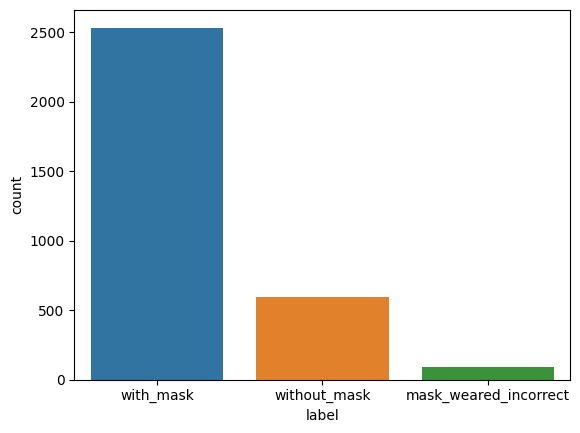

In [17]:
sns.countplot(x=df["label"])
plt.show()


In [33]:
def load_data(path, img_size, num_files): 

  data = []
  labels = []
  for i in range(num_files[0],num_files[1]):
    img = Image.open(path + str(i) + '.png')
    img_arr = np.array(img)
    img_input = df.loc[df['filename'] == 'maksssksksss' + str(i)]
    for ind in img_input.index:
      img_cropped = img_arr[int(img_input['ymin'][ind]):int(img_input['ymax'][ind]), int(img_input['xmin'][ind]):int(img_input['xmax'][ind]), :3]
      resized_img = cv2.resize(img_cropped, img_size, cv2.INTER_LINEAR)
      gray=cv2.cvtColor(resized_img,cv2.COLOR_BGR2GRAY) 
      data.append(gray)
      if(img_input['label'][ind] == 'with_mask'):
        labels.append(0)
      elif(img_input['label'][ind] == 'without_mask'):
        labels.append(1)
      else:
        labels.append(2)

  data=np.array(data)/255.0
  data=np.reshape(data,(data.shape[0],img_size[0],img_size[1],1))
  labels=np.array(labels)
  return data, labels


In [34]:
# load data into size (64, 64)
img_size = (100, 100)
batch_size = 64 # training sample number per batch
data_range = [0,853]


In [35]:
# load training dataset
data, labels = load_data(img_path, img_size, data_range)
new_labels = np_utils.to_categorical(labels)
np.save('data',data)
np.save('target',new_labels)

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = data[0][0][38][0], data[0][1][38]
label = int(np.array(label))
print(class_names[label])
imshow(img)

In [37]:
data=np.load('data.npy')
target=np.load('target.npy')

In [48]:
model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
model.add(Dropout(0.5))
#Flatten layer to stack the output convolutions from second convolution layer
model.add(Dense(50,activation='relu'))
#Dense layer of 64 neurons
model.add(Dense(3,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [49]:
train_data, test_data, train_target, test_target=train_test_split(data,target,test_size=0.1)

In [51]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data, train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.8343

INFO:tensorflow:Assets written to: model-001.model\assets


INFO:tensorflow:Assets written to: model-001.model\assets


73/73 [==============================] - 65s 892ms/step - loss: 0.4040 - accuracy: 0.8343 - val_loss: 0.5031 - val_accuracy: 0.8086
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8636

INFO:tensorflow:Assets written to: model-002.model\assets


INFO:tensorflow:Assets written to: model-002.model\assets


73/73 [==============================] - 61s 842ms/step - loss: 0.3432 - accuracy: 0.8636 - val_loss: 0.4004 - val_accuracy: 0.8345
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8744

INFO:tensorflow:Assets written to: model-003.model\assets


INFO:tensorflow:Assets written to: model-003.model\assets


73/73 [==============================] - 70s 962ms/step - loss: 0.3319 - accuracy: 0.8744 - val_loss: 0.3968 - val_accuracy: 0.8362
Epoch 4/20
73/73 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8878

INFO:tensorflow:Assets written to: model-004.model\assets


INFO:tensorflow:Assets written to: model-004.model\assets


73/73 [==============================] - 70s 952ms/step - loss: 0.3078 - accuracy: 0.8878 - val_loss: 0.3875 - val_accuracy: 0.8466
Epoch 5/20
73/73 [==============================] - 59s 816ms/step - loss: 0.2711 - accuracy: 0.9020 - val_loss: 0.3889 - val_accuracy: 0.8448
Epoch 6/20
73/73 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.8947

INFO:tensorflow:Assets written to: model-006.model\assets


INFO:tensorflow:Assets written to: model-006.model\assets


73/73 [==============================] - 62s 852ms/step - loss: 0.2815 - accuracy: 0.8947 - val_loss: 0.3664 - val_accuracy: 0.8638
Epoch 7/20
73/73 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9089

INFO:tensorflow:Assets written to: model-007.model\assets


INFO:tensorflow:Assets written to: model-007.model\assets


73/73 [==============================] - 62s 855ms/step - loss: 0.2533 - accuracy: 0.9089 - val_loss: 0.3449 - val_accuracy: 0.8621
Epoch 8/20
73/73 [==============================] - 58s 790ms/step - loss: 0.2320 - accuracy: 0.9167 - val_loss: 0.3701 - val_accuracy: 0.8638
Epoch 9/20
73/73 [==============================] - 63s 861ms/step - loss: 0.2314 - accuracy: 0.9137 - val_loss: 0.3637 - val_accuracy: 0.8759
Epoch 10/20
73/73 [==============================] - 66s 903ms/step - loss: 0.2260 - accuracy: 0.9154 - val_loss: 0.4662 - val_accuracy: 0.8379
Epoch 11/20
73/73 [==============================] - 60s 823ms/step - loss: 0.2081 - accuracy: 0.9206 - val_loss: 0.3554 - val_accuracy: 0.8517
Epoch 12/20
73/73 [==============================] - 67s 916ms/step - loss: 0.1928 - accuracy: 0.9344 - val_loss: 0.3852 - val_accuracy: 0.8724
Epoch 13/20
73/73 [==============================] - 67s 920ms/step - loss: 0.1855 - accuracy: 0.9331 - val_loss: 0.3742 - val_accuracy: 0.8534
Epoch 

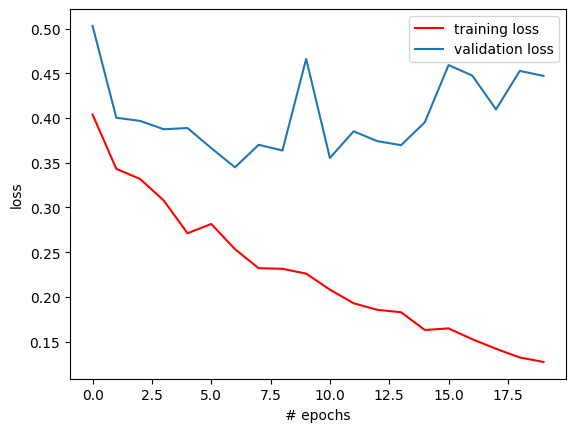

In [52]:
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

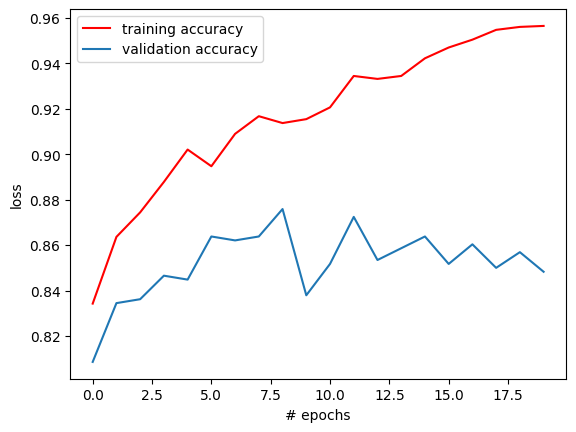

In [53]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()